In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.calc import dewpoint_from_relative_humidity
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

In [2]:
rap = xr.open_mfdataset("/glade/scratch/cbecker/ptype_case_studies/kentucky/rap/20220223/0000/*.nc", concat_dim='time', combine='nested')

In [3]:
# create dewpoint from relative humidity since RAP doesn't natively carry dewpoint
rap['dpt'] = dewpoint_from_relative_humidity(rap['t'] * units.degC,
                                             rap['r'].values / 100)

In [4]:
rap

<xarray.Dataset>
Dimensions:                  (time: 18, heightAboveGround: 21, y: 337, x: 451,
                              isobaricInhPa: 37)
Coordinates:
  * time                     (time) datetime64[ns] 2022-02-23 ... 2022-02-23
    step                     (time) timedelta64[ns] 01:00:00 ... 18:00:00
  * isobaricInhPa            (isobaricInhPa) float32 1e+03 975.0 ... 125.0 100.0
    latitude                 (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    longitude                (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    valid_time               (time) datetime64[ns] 2022-02-23T01:00:00 ... 20...
    y_projection_coordinate  (y) float32 dask.array<chunksize=(337,), meta=np.ndarray>
    x_projection_coordinate  (x) float32 dask.array<chunksize=(451,), meta=np.ndarray>
Dimensions without coordinates: heightAboveGround, y, x
Data variables: (12/29)
    t_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    dpt_h                    (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    u_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    v_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    isobaricInhPa_h          (time, heightAboveGround, y, x) float64 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    t                        (time, isobaricInhPa, y, x) float32 dask.array<chunksize=(1, 37, 337, 451), meta=np.ndarray>
    ...                       ...
    ML_snow                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_csnow                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_icep                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cicep                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_frzr                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cfrzr                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>

In [10]:
def quantile_composites_skewt(ds: xr.Dataset, y_col: str, 
                              cols: list[str], colors: list[str], 
                              quantile_mid: bool = True,
                              debug: bool = False) -> None:
    '''function to output composite soundings with shaded quantile regions corresponding to 25/75
       and 10/90 quantiles. input list of predictions to plot and corresponding colors'''

    
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig)
    quantile = True
    
    if debug:
        quantile_mid, quantile = False, False

    y = ds[y_col].values
    
    for ptype,c in zip(cols, colors):
        subset = ds.where(ds[ptype]==1)
        temperature_profile = subset['t_h'].mean(dim=('x','y','time'))
        line, = skew.plot(y, temperature_profile, c, linewidth=2)
        line.set_label(ptype)
        
        if quantile:
            upper_quantile = subset['t_h'].chunk(dict(time=-1)).quantile(0.9, dim=('x','y','time'))
            lower_quantile = subset['t_h'].chunk(dict(time=-1)).quantile(0.1, dim=('x','y','time'))
            skew.shade_area(y, lower_quantile, upper_quantile, alpha=0.1, color=c)
        if quantile_mid:
            upper_quantile = subset['t_h'].chunk(dict(time=-1)).quantile(0.75, dim=('x','y','time'))
            lower_quantile = subset['t_h'].chunk(dict(time=-1)).quantile(0.25, dim=('x','y','time'))
            skew.shade_area(y, lower_quantile, upper_quantile, alpha=0.2, color=c)
        #dewpoint_profile = subset['dpt'].isel(x=x, y=y, time=time_step).values
        
    ax = skew.ax

    ax.set_title(f"Skew T when models predicts {cols[0][1:]}")
    ax.set_xlabel('Temperature (C)')
    ax.set_ylabel('Isobars (hPa)')
    ax.legend()


**Recall our calibration plots:**

![alt text](skewT_viz/MLCalibration.png "Calibration of ML model")

In [ ]:
quantile_composites_skewt(rap, 'heightAboveGround', ['cicep', 'ML_cicep'], ['blue', 'green'], debug=True)


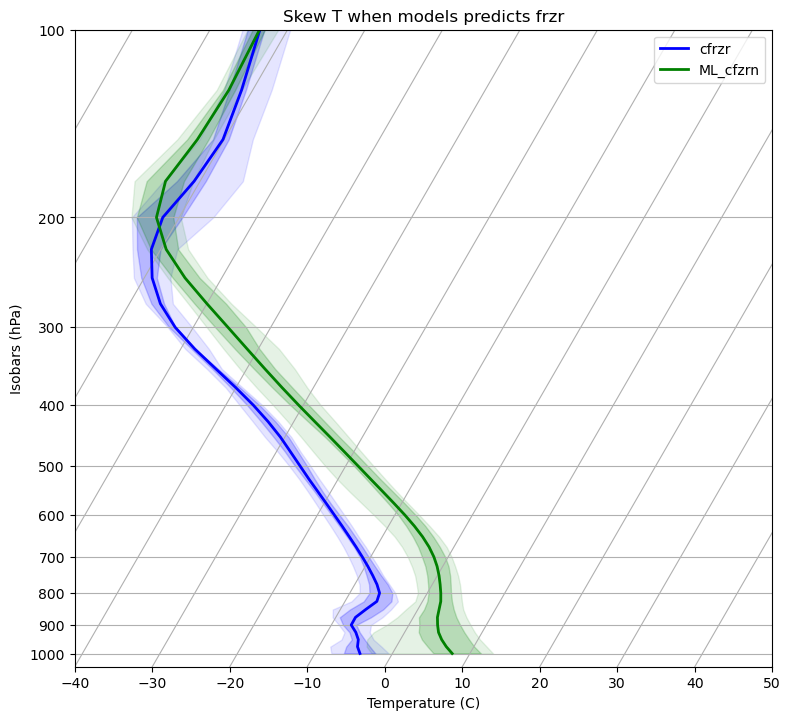

In [11]:
quantile_composites_skewt(rap, 'isobaricInhPa', ['cfrzr', 'ML_cfzrn'], ['blue', 'green'], True)

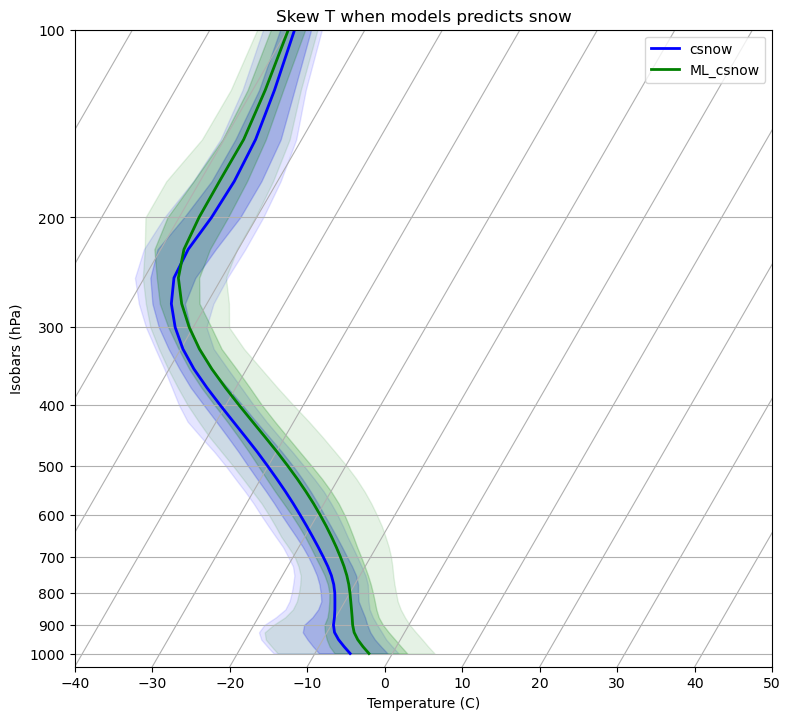

In [12]:
quantile_composites_skewt(rap, 'isobaricInhPa', ['csnow', 'ML_csnow'], ['blue', 'green'], True)

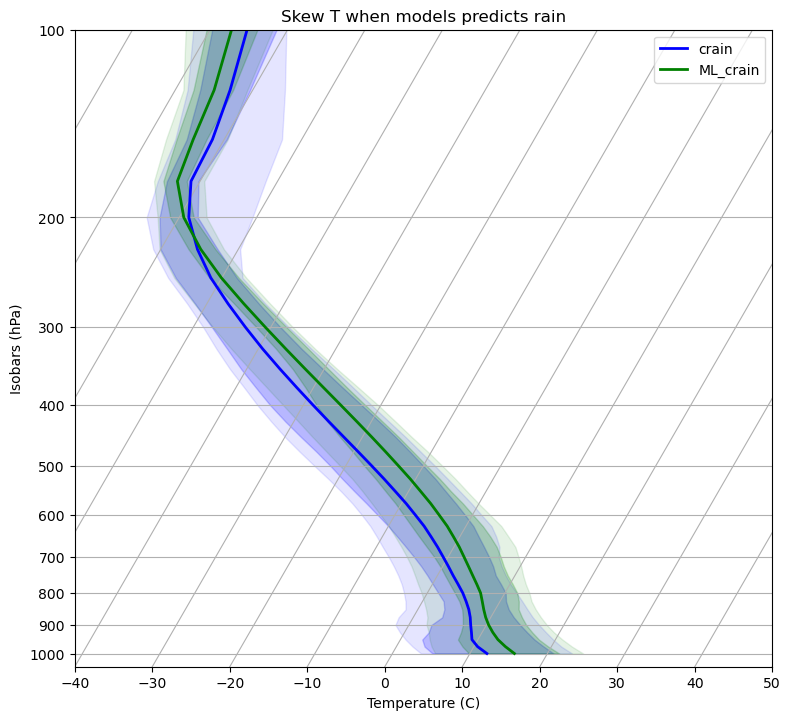

In [9]:
quantile_composites_skewt(rap, 'isobaricInhPa', ['crain', 'ML_crain'], ['blue', 'green'], True)

In [10]:
u, c = np.unique(rap.ML_cicep.values, return_counts=True)

In [1]:
test_1 = pd.read_parquet("/glade/p/cisl/aiml/ai2es/winter_ptypes/models/evidential_weighted/evaluate/test_0.parquet")

NameError: name 'pd' is not defined